In [1]:
import numpy as np 
import pandas as pd 
from data_processing import generate_vocab, process_data, create_dataloaders
from model import get_pretrained_emb, EncoderRNN, DecoderRNN, DecoderAttnRNN, EncoderDecoder, EncoderDecoderAttn
from train_eval import train_and_eval, count_parameters, summarize_results, plot_single_learning_curve, load_experiment_log
import pickle as pkl 
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# model identification
SRC_LANG = 'vi'
TARG_LANG = 'en'

# data processing params  
SRC_MAX_SENTENCE_LEN = 10
TARG_MAX_SENTENCE_LEN = 10
SRC_VOCAB_SIZE = 30000 
TARG_VOCAB_SIZE = 30000 

# model architecture params 
NETWORK_TYPE = 'rnn'
RNN_CELL_TYPE = 'gru'
NUM_LAYERS = 2 
ENC_HIDDEN_DIM = 512
DEC_HIDDEN_DIM = 2 * ENC_HIDDEN_DIM 
TEACHER_FORCING_RATIO = 1
CLIP_GRAD_MAX_NORM = 1
ENC_DROPOUT = 0.2 
DEC_DROPOUT = 0.2 
ATTENTION_TYPE = 'multiplicative'

# training params  
BATCH_SIZE = 64 #32
NUM_EPOCHS = 15
LR = 0.0003 # 0.0005
OPTIMIZER = 'Adam'
LAZY_TRAIN = False

# name the model 
if NETWORK_TYPE == 'rnn': 
    MODEL_NAME = '{}-rnn-{}-attn'.format(SRC_LANG, ATTENTION_TYPE)
elif NETWORK_TYPE == 'cnn': 
    MODEL_NAME = '{}-cnn'.format(SRC_LANG)
    
print("Preparing to train model {}".format(MODEL_NAME))

Preparing to train model vi-rnn-multiplicative-attn


In [3]:
# store as dict to save to results later 
params = {'model_name': MODEL_NAME, 'src_lang': SRC_LANG, 'targ_lang': TARG_LANG, 'rnn_cell_type': RNN_CELL_TYPE, 
          'src_max_sentence_len': SRC_MAX_SENTENCE_LEN, 'targ_max_sentence_len': TARG_MAX_SENTENCE_LEN, 
          'src_vocab_size': SRC_VOCAB_SIZE, 'targ_vocab_size': TARG_VOCAB_SIZE, 
          'num_layers': NUM_LAYERS, 'enc_hidden_dim': ENC_HIDDEN_DIM, 'dec_hidden_dim': DEC_HIDDEN_DIM,
          'teacher_forcing_ratio': TEACHER_FORCING_RATIO, 'clip_grad_max_norm': CLIP_GRAD_MAX_NORM,
          'enc_dropout': ENC_DROPOUT, 'dec_dropout': DEC_DROPOUT, 'attention_type': ATTENTION_TYPE, 
          'batch_size': BATCH_SIZE, 'num_epochs': NUM_EPOCHS, 'learning_rate': LR, 'optimizer': OPTIMIZER, 
          'lazy_train': LAZY_TRAIN} 

In [4]:
# takes a long time to process, save to pickle for reimport in future 
# vocab = generate_vocab(SRC_LANG, TARG_LANG, SRC_VOCAB_SIZE, TARG_VOCAB_SIZE)
# vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
# pkl.dump(vocab, open(vocab_filename, "wb"))

In [5]:
# reload from pickle 
vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
vocab = pkl.load(open(vocab_filename, "rb"))
data = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, filter_long=False)
data_minibatch = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, sample_limit=BATCH_SIZE, filter_long=False) 
data_minitrain = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, sample_limit=1000, filter_long=False)

In [6]:
# create dataloaders 
loaders_full = create_dataloaders(data, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minibatch = create_dataloaders(data_minibatch, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minitrain = create_dataloaders(data_minitrain, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)

In [7]:
# define model 

encoder = EncoderRNN(rnn_cell_type=RNN_CELL_TYPE, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, 
                     src_max_sentence_len=SRC_MAX_SENTENCE_LEN, enc_dropout=ENC_DROPOUT, 
                     pretrained_word2vec=get_pretrained_emb(vocab[SRC_LANG]['word2vec'], vocab[SRC_LANG]['token2id']))

if ATTENTION_TYPE == 'without': 
    # without attention 
    decoder = DecoderRNN(dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS,
                         targ_vocab_size=TARG_VOCAB_SIZE, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
                         pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], 
                                                                vocab[TARG_LANG]['token2id']))
    model = EncoderDecoder(encoder, decoder, vocab[TARG_LANG]['token2id']).to(device)
    
else: 
    # with attention 
    decoder = DecoderAttnRNN(rnn_cell_type=RNN_CELL_TYPE, dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, 
                             num_layers=NUM_LAYERS, targ_vocab_size=TARG_VOCAB_SIZE, 
                             src_max_sentence_len=SRC_MAX_SENTENCE_LEN, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
                             dec_dropout=DEC_DROPOUT, attention_type=ATTENTION_TYPE,
                             pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], 
                                                                    vocab[TARG_LANG]['token2id']))
    model = EncoderDecoderAttn(encoder, decoder, vocab[TARG_LANG]['token2id']).to(device) 
    

In [8]:
model, results = train_and_eval(
    model=model, loaders_full=loaders_full, loaders_minibatch=loaders_minibatch, loaders_minitrain=loaders_minitrain, 
    params=params, vocab=vocab, print_intermediate=100, save_checkpoint=True, save_to_log=True, 
    lazy_eval=False, print_attn=True, inspect_samples=1)

Epoch: 0.00, Train Loss: 10.23, Val Loss: 10.24, Train BLEU: 0.29, Val BLEU: 0.27, Minutes Elapsed: 0.20
Sampling from training predictions...
Source: cũng gần vào thời_kỳ này , tôi nghĩ nó được
Reference: it &apos;s around the same time , i think
Model: <SOS> and a the the the the the the the
Attention Weights: tensor([[0.0718, 0.0886, 0.1038, 0.1185, 0.1144, 0.1204, 0.1103, 0.1102, 0.0919,
         0.0702],
        [0.0815, 0.0923, 0.1032, 0.1120, 0.1075, 0.1114, 0.1062, 0.1074, 0.0965,
         0.0820],
        [0.0848, 0.0928, 0.1029, 0.1098, 0.1032, 0.1070, 0.1037, 0.1072, 0.1000,
         0.0886],
        [0.0885, 0.0943, 0.1029, 0.1073, 0.1009, 0.1035, 0.1015, 0.1057, 0.1015,
         0.0939],
        [0.0894, 0.0955, 0.1013, 0.1053, 0.1002, 0.1042, 0.1003, 0.1048, 0.1014,
         0.0975],
        [0.0914, 0.0962, 0.1011, 0.1038, 0.1001, 0.1029, 0.0994, 0.1032, 0.1016,
         0.1003],
        [0.0934, 0.0968, 0.1010, 0.1027, 0.1002, 0.1018, 0.0991, 0.1019, 0.1014,
         0.

Epoch: 0.19, Train Loss: 5.90, Val Loss: 6.12, Train BLEU: 0.86, Val BLEU: 0.73, Minutes Elapsed: 10.14
Sampling from training predictions...
Source: có nhiều căn phòng cũng tương_tự trên đất_nước này .
Reference: other places around the country had similar rooms .
Model: <SOS> and i the the the the the the the
Attention Weights: tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9738, 0.0262, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9987, 0.0013,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3001, 0.6999,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0014, 0.9972,
         0.0014],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7069,
         0.2931],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0854,
         0.9146],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0

Epoch: 0.38, Train Loss: 5.45, Val Loss: 5.61, Train BLEU: 2.82, Val BLEU: 3.08, Minutes Elapsed: 20.00
Sampling from training predictions...
Source: và chúng không còn hoàn_toàn giống nhau nữa . <EOS>
Reference: and they no longer have to be exactly the
Model: <SOS> and they &apos;s the to . . . <EOS>
Attention Weights: tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0045, 0.0051, 0.9904, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.9740, 0.0000, 0.0026, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0235],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
  

Epoch: 0.58, Train Loss: 5.12, Val Loss: 5.24, Train BLEU: 4.69, Val BLEU: 4.30, Minutes Elapsed: 29.88
Sampling from training predictions...
Source: mọi người có_thể rất phấn_khởi , cho_rằng , " ồ
Reference: everyone that sees this gets excited , and says
Model: <SOS> so can to , , , &quot; &quot; ,
Attention Weights: tensor([[0.0000, 0.0000, 0.8995, 0.1004, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.9999, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.4618, 0.5330, 0.0052, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9930, 0.0069, 0.0001, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0001, 0.0183, 0.9816,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
    

Epoch: 0.77, Train Loss: 4.94, Val Loss: 5.03, Train BLEU: 5.74, Val BLEU: 5.29, Minutes Elapsed: 39.70
Sampling from training predictions...
Source: sau_đó họ xé nó đi . không có bất_kỳ gian_lận
Reference: then they shredded it . no cheating whatsoever .
Model: <SOS> then they they it it it &apos;s it it
Attention Weights: tensor([[0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.9919, 0.0000, 0.0081, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.9994, 0.0006, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0003, 0.0003, 0.9990, 0.0004, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9939, 0.0061, 0.0000,

Epoch: 0.96, Train Loss: 4.81, Val Loss: 4.86, Train BLEU: 5.98, Val BLEU: 5.20, Minutes Elapsed: 49.52
Sampling from training predictions...
Source: chúng_ta hay có xu_hướng , như là một xã_hội ,
Reference: and we have a tendency , as a society
Model: <SOS> we we we to , , but we ,
Attention Weights: tensor([[1.0000e+00, 4.6054e-20, 2.5302e-34, 2.1389e-40, 2.5232e-30, 1.1517e-27,
         1.2991e-32, 8.0907e-33, 2.1334e-32, 5.8282e-30],
        [1.0000e+00, 2.5244e-12, 1.0199e-19, 3.6521e-35, 1.2353e-32, 6.3721e-32,
         1.0411e-32, 9.3376e-34, 2.5766e-40, 1.2430e-42],
        [3.5688e-02, 9.6380e-01, 5.1447e-04, 2.3321e-22, 2.8165e-22, 6.6586e-24,
         7.8232e-24, 5.0385e-26, 1.2946e-34, 6.9254e-40],
        [9.7886e-01, 2.1143e-02, 3.5836e-08, 7.3186e-28, 3.4895e-24, 9.4728e-27,
         6.2237e-25, 1.7915e-26, 8.4593e-37, 5.8657e-41],
        [1.7198e-20, 1.9258e-06, 5.6968e-01, 4.3030e-01, 2.2029e-05, 1.4808e-17,
         8.0583e-21, 1.9273e-20, 5.4621e-25, 1.0476e-29],
  

Epoch: 1.10, Train Loss: 4.40, Val Loss: 4.79, Train BLEU: 7.67, Val BLEU: 6.84, Minutes Elapsed: 56.50
Sampling from training predictions...
Source: chúng_ta có_thể nghĩ đến làm thế_nào để kiểm_tra trực_giác này
Reference: we can think about how we &apos;re going to
Model: <SOS> we can think to do to do do to
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.9999, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0001, 0.9999, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0246, 0.8236, 0.1517, 0.0001, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0001, 0.0416, 0.9582, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9999, 0.0000, 0.

Epoch: 1.29, Train Loss: 4.36, Val Loss: 4.71, Train BLEU: 7.28, Val BLEU: 6.08, Minutes Elapsed: 66.29
Sampling from training predictions...
Source: những bộ phim được biên_đạo và bối cảnh_hoá . <EOS>
Reference: the films were curated and contextualized . <EOS> <PAD>
Model: <SOS> the are are the to and . <EOS> <EOS>
Attention Weights: tensor([[1.0000e+00, 7.2276e-16, 2.8842e-12, 1.0579e-13, 3.4292e-18, 1.4037e-25,
         4.4574e-21, 3.7044e-23, 9.7820e-23, 4.9888e-18],
        [9.9998e-01, 2.1201e-05, 4.2899e-10, 1.5430e-06, 7.0899e-16, 1.9195e-32,
         1.0194e-33, 3.1593e-39, 4.2272e-39, 2.7989e-39],
        [5.7506e-09, 8.3760e-11, 4.6143e-05, 9.9995e-01, 6.0867e-10, 4.0411e-21,
         1.7866e-30, 1.6204e-39, 9.2665e-40, 2.5049e-39],
        [5.4976e-19, 4.1570e-15, 4.3484e-10, 1.0000e+00, 2.8413e-06, 6.6267e-18,
         2.0751e-27, 4.7633e-35, 2.3758e-37, 3.7965e-37],
        [1.1566e-13, 3.4560e-12, 2.0291e-08, 6.2977e-01, 3.7023e-01, 1.0569e-09,
         1.7525e-16, 2.30

Epoch: 1.48, Train Loss: 4.31, Val Loss: 4.59, Train BLEU: 7.27, Val BLEU: 6.59, Minutes Elapsed: 76.19
Sampling from training predictions...
Source: khi sự_nghiệp của mình phát_triển , david byrne từ chơi
Reference: as his career grew , david byrne went from
Model: <SOS> when the the of , , , , ,
Attention Weights: tensor([[1.0000e+00, 3.0194e-11, 1.1308e-17, 3.5670e-14, 7.0046e-24, 1.7156e-26,
         1.1790e-13, 6.1650e-16, 8.6741e-24, 5.7678e-26],
        [9.9973e-01, 2.7192e-04, 8.3653e-10, 7.9500e-11, 1.3507e-20, 3.6558e-22,
         2.5429e-22, 1.0635e-28, 2.9170e-27, 7.9990e-35],
        [8.4509e-04, 9.9903e-01, 1.2186e-04, 3.2398e-07, 6.0961e-15, 4.1277e-19,
         2.1089e-20, 3.2185e-21, 8.2053e-20, 3.7230e-29],
        [8.3850e-09, 1.2878e-06, 1.7182e-04, 9.9881e-01, 1.0153e-03, 2.2782e-07,
         3.1757e-15, 1.0141e-15, 2.6189e-12, 3.7577e-19],
        [4.7989e-18, 8.1811e-19, 1.1022e-12, 1.4985e-05, 6.3516e-03, 9.9363e-01,
         3.7194e-13, 5.2879e-18, 1.5251e-14, 

Epoch: 1.67, Train Loss: 4.27, Val Loss: 4.53, Train BLEU: 7.25, Val BLEU: 6.98, Minutes Elapsed: 85.99
Sampling from training predictions...
Source: vì tôi bị bỏng 70 % cơ_thể nên mất khoảng
Reference: and because i had 70 percent of my body
Model: <SOS> so i i i about percent percent the of
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.9999, 0.0000, 0.0000, 0.0001, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.8325, 0.1674, 0.0001, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0

Epoch: 1.86, Train Loss: 4.22, Val Loss: 4.45, Train BLEU: 8.24, Val BLEU: 7.83, Minutes Elapsed: 95.86
Sampling from training predictions...
Source: để chỉ cho các bạn trò_chơi này , tôi sẽ
Reference: in order to teach you this game , i
Model: <SOS> to to to you this , , , i
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0002, 0.0000, 0.0000, 0.0048, 0.9949, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.9995, 0.0001, 0.0004, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0205, 0.0084, 0.9704, 0.0006, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0005, 0.7238, 0.2758,
         0.0000],
        [0.

Epoch: 2.05, Train Loss: 3.68, Val Loss: 4.45, Train BLEU: 9.61, Val BLEU: 8.36, Minutes Elapsed: 105.41
Sampling from training predictions...
Source: điều này là đúng , vì_vậy nếu bạn chơi trò_chơi
Reference: this is true , so if you play this
Model: <SOS> this is , , if if you &apos;re to
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.4577, 0.5423, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.1947, 0.8053, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.9999, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9955, 0.0045, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0004, 0.9996, 0.0000,
         0.000

Epoch: 2.24, Train Loss: 3.82, Val Loss: 4.39, Train BLEU: 9.00, Val BLEU: 7.89, Minutes Elapsed: 115.32
Sampling from training predictions...
Source: ý_tưởng ở đây là nếu chúng_ta mở_rộng cánh_cửa khoa_học và
Reference: the idea is that if you open up the
Model: <SOS> the idea is is we we &apos;re to and
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.9999, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0055, 0.9945, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,

Epoch: 2.43, Train Loss: 3.85, Val Loss: 4.34, Train BLEU: 8.55, Val BLEU: 8.39, Minutes Elapsed: 125.11
Sampling from training predictions...
Source: không_sao , bởi_vì bạn đã học được một kỹ_năng mới
Reference: that &apos;s okay , because you learned a new
Model: <SOS> no , because , because you &apos;ve a a
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.9999, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.9988, 0.0012, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0003, 0.9997, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.1098, 0.8901, 0.0001, 0.0000, 0.0000, 0.

Epoch: 2.62, Train Loss: 3.80, Val Loss: 4.31, Train BLEU: 9.71, Val BLEU: 9.33, Minutes Elapsed: 134.92
Sampling from training predictions...
Source: đó hình_thành lớp ô bảo_vệ vậy là nước tác_động vào
Reference: it &apos;s an umbrella of air all across it
Model: <SOS> it &apos;s a a of the that that that
Attention Weights: tensor([[1.0000e+00, 2.4354e-18, 1.0358e-19, 1.1458e-29, 2.2358e-22, 3.5135e-24,
         7.7171e-25, 1.5836e-29, 5.1680e-29, 8.4533e-24],
        [1.0000e+00, 9.9517e-15, 1.8808e-13, 4.5155e-23, 1.0323e-22, 3.8439e-28,
         8.1789e-28, 1.2826e-35, 1.0560e-37, 3.0066e-37],
        [5.5044e-04, 9.9929e-01, 1.5759e-04, 6.4733e-14, 5.0480e-21, 1.0536e-28,
         4.1798e-25, 1.4908e-34, 2.0867e-39, 7.8333e-41],
        [4.1027e-18, 3.3611e-07, 9.9998e-01, 2.1793e-05, 4.2173e-11, 7.4897e-21,
         2.5279e-22, 6.5502e-26, 2.9921e-31, 4.3889e-34],
        [1.2504e-20, 3.4666e-12, 9.9989e-01, 1.0775e-04, 1.3433e-06, 8.8294e-18,
         8.4732e-22, 1.0233e-23, 5.7

Epoch: 2.82, Train Loss: 3.80, Val Loss: 4.29, Train BLEU: 9.86, Val BLEU: 8.77, Minutes Elapsed: 144.77
Sampling from training predictions...
Source: chúng_ta thích_ứng . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: we adapt . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> we are . . . <EOS> <EOS> <EOS> <EOS>
Attention Weights: tensor([[0.9948, 0.0000, 0.0000, 0.0052, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.7975, 0.2009, 0.0017, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0689, 0.9311, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 

Epoch: 3.00, Train Loss: 3.78, Val Loss: 4.30, Train BLEU: 9.79, Val BLEU: 8.57, Minutes Elapsed: 154.16
Sampling from training predictions...
Source: khi peter di_chuyển cánh_tay , chấm màu vàng mà bạn
Reference: when peter moves his arm , that yellow spot
Model: <SOS> when when was was the , the the the
Attention Weights: tensor([[1.0000e+00, 6.3735e-25, 2.3841e-30, 7.2595e-39, 1.0518e-32, 9.9768e-32,
         1.1821e-27, 5.0340e-29, 1.2476e-25, 2.3912e-25],
        [1.0000e+00, 1.4677e-11, 1.4674e-11, 3.1410e-29, 9.9316e-36, 2.5795e-38,
         2.9145e-37, 3.7835e-44, 1.7698e-42, 2.3490e-41],
        [8.2938e-15, 3.9982e-07, 1.0000e+00, 4.0647e-21, 1.4885e-35, 4.1263e-38,
         7.5599e-40, 2.3822e-44, 1.0089e-43, 2.3206e-42],
        [1.3982e-16, 1.2527e-18, 1.0000e+00, 1.0138e-06, 1.7686e-25, 4.4602e-31,
         1.4777e-31, 2.1108e-35, 1.1120e-30, 6.3336e-30],
        [7.3670e-18, 2.6535e-26, 1.7864e-05, 9.9998e-01, 9.9578e-12, 5.7265e-19,
         9.9022e-18, 3.6434e-23, 1.71

Epoch: 3.19, Train Loss: 3.36, Val Loss: 4.26, Train BLEU: 10.31, Val BLEU: 9.09, Minutes Elapsed: 163.92
Sampling from training predictions...
Source: bạn có_thể làm ra một dụng_cụ kiểm_duyệt sinh_học từ men
Reference: you can make a biocensor out of yeast to
Model: <SOS> you can do a a of of the .
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.7654, 0.1449, 0.0897, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0112, 0.9888, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9984, 0.0002, 0.0014,
     

Epoch: 3.38, Train Loss: 3.45, Val Loss: 4.25, Train BLEU: 10.81, Val BLEU: 9.07, Minutes Elapsed: 173.76
Sampling from training predictions...
Source: họ không chú_ý vào trò_chơi . họ trông có_vẻ yếu
Reference: they &apos;re not paying attention . they look kind
Model: <SOS> they don &apos;t going to . they &apos;re it
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0138, 0.1162, 0.1973, 0.6727, 

Epoch: 3.58, Train Loss: 3.48, Val Loss: 4.21, Train BLEU: 10.64, Val BLEU: 9.62, Minutes Elapsed: 183.53
Sampling from training predictions...
Source: và họ gian_lận rõ_ràng và nghiêm_trọng <EOS> <PAD> <PAD> <PAD>
Reference: and they clearly cheated in a very , very
Model: <SOS> and they they back and and . . .
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 

Epoch: 3.77, Train Loss: 3.48, Val Loss: 4.21, Train BLEU: 9.40, Val BLEU: 9.70, Minutes Elapsed: 193.36
Sampling from training predictions...
Source: khi_ấy tôi bị bỏng nặng . <EOS> <PAD> <PAD> <PAD>
Reference: i was burned very badly . <EOS> <PAD> <PAD>
Model: <SOS> my father my to . . <EOS> was .
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.9995, 0.0005, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0001, 0.9999, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.9901, 0.0099, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0034, 0.9938, 0.0028, 0.0000, 0.0000, 0.0000,
     

Epoch: 3.96, Train Loss: 3.41, Val Loss: 4.18, Train BLEU: 10.47, Val BLEU: 9.35, Minutes Elapsed: 203.21
Sampling from training predictions...
Source: đó là tính sợ nước . <EOS> <PAD> <PAD> <PAD>
Reference: it &apos;s that afraid of the water . <EOS>
Model: <SOS> it &apos;s a eternal . . . . <EOS>
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0059, 0.9941, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.9983, 0.0017, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.4533, 0.5465, 0.0000, 0.0001, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
      

Epoch: 4.19, Train Loss: 3.04, Val Loss: 4.21, Train BLEU: 12.93, Val BLEU: 9.54, Minutes Elapsed: 215.16
Sampling from training predictions...
Source: tôi không thấy bất_cứ ai gửi tin nhắn hoặc kiểm_tra
Reference: i didn &apos;t see anybody sending text messages or
Model: <SOS> i don &apos;t know anyone anyone to or or
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0308, 0.9691, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0013, 0.0002, 0.9986, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9949, 0.0050, 

Epoch: 4.38, Train Loss: 3.14, Val Loss: 4.20, Train BLEU: 12.76, Val BLEU: 9.63, Minutes Elapsed: 224.90
Sampling from training predictions...
Source: bạn đoán ra chiếc nào khô rồi chứ ? <EOS>
Reference: did you guess the one that was dry ?
Model: <SOS> you do see the the ? ? ? ?
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0354, 0.9635, 0.0011, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0001, 0.9999, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4549, 0.0009, 0.0001, 0.5441,
         0.0000],
      

Epoch: 4.58, Train Loss: 3.19, Val Loss: 4.16, Train BLEU: 12.15, Val BLEU: 10.01, Minutes Elapsed: 234.70
Sampling from training predictions...
Source: một_vài người lo_sợ những cô gái không thích mình .
Reference: see , some people might fear girls not liking
Model: <SOS> some of kids are didn &apos;t &apos;t . <EOS>
Attention Weights: tensor([[1.0000e+00, 1.5661e-10, 1.0074e-20, 3.3618e-26, 1.8509e-26, 3.8334e-32,
         1.6318e-28, 5.6754e-29, 9.1783e-23, 1.5836e-19],
        [1.0000e+00, 8.7290e-07, 1.5215e-14, 7.8941e-24, 3.8757e-23, 1.0490e-30,
         4.0897e-39, 5.2331e-40, 1.3363e-38, 1.7170e-40],
        [1.9227e-13, 6.0455e-04, 9.9940e-01, 8.4308e-09, 4.7426e-14, 1.2823e-18,
         3.1582e-25, 1.3838e-30, 1.4789e-32, 5.8612e-35],
        [5.3027e-20, 6.2377e-11, 3.4909e-01, 1.4839e-01, 4.8575e-01, 1.6773e-02,
         1.7744e-08, 4.8467e-16, 6.4175e-20, 1.4406e-24],
        [7.2074e-27, 1.4043e-20, 4.3106e-16, 2.4892e-08, 3.2139e-03, 9.8653e-01,
         1.0252e-02, 4.

Epoch: 4.77, Train Loss: 3.19, Val Loss: 4.17, Train BLEU: 11.72, Val BLEU: 10.28, Minutes Elapsed: 244.66
Sampling from training predictions...
Source: và chuyện mới xảy ra ở đây là tôi đứng
Reference: so what happened now is i &apos;m standing here
Model: <SOS> and what happened happened happened i i i here
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.9995, 0.0000, 0.0005, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.9925, 0.0075, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.1094, 0.8906, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0001, 0.9908, 0.0092, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0136, 0.9051, 0.0066, 0.0746,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0001, 0.9

Epoch: 4.96, Train Loss: 3.10, Val Loss: 4.16, Train BLEU: 11.80, Val BLEU: 9.51, Minutes Elapsed: 254.59
Sampling from training predictions...
Source: " tại_sao chúng_ta không làm lâu hơn 1 chút 2
Reference: why don &apos;t we take it a little longer
Model: <SOS> &quot; why don we we to more more more
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0011, 0.9989, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.4813, 0.5187, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0077, 0.6114, 0.3694, 0.0115, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9999, 0.0001, 0.0000, 0.0000,
  

Epoch: 5.14, Train Loss: 2.74, Val Loss: 4.16, Train BLEU: 15.15, Val BLEU: 10.36, Minutes Elapsed: 264.16
Sampling from training predictions...
Source: tôi nói " vật ngón_cái với rất đông người .
Reference: i said &quot; massively multiplayer thumb-wrestling . &quot; <EOS>
Model: <SOS> i said , &quot; multiplayer . <EOS> <EOS> .
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9973, 0.0027, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0009

Epoch: 5.34, Train Loss: 2.91, Val Loss: 4.18, Train BLEU: 13.45, Val BLEU: 9.87, Minutes Elapsed: 274.30
Sampling from training predictions...
Source: có_phải chúng_ta sáng_tạo nên mọi thứ với một địa_điểm ,
Reference: do we all make things with a venue ,
Model: <SOS> what we make a a new a , ,
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0379, 0.9621, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0112, 0.9885, 0.0003, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0001, 0.9994, 0.0006, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9997, 0.0003, 0.0000,
         

Epoch: 5.53, Train Loss: 2.91, Val Loss: 4.17, Train BLEU: 14.16, Val BLEU: 10.22, Minutes Elapsed: 284.45
Sampling from training predictions...
Source: bằng cách chọn " khách_sạn rwanda " bọn trẻ đã
Reference: in choosing &quot; hotel rwanda , &quot; they explored
Model: <SOS> by &apos;s &quot; &quot; &quot; &quot; &quot; the the
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.9526, 0.0473, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.6119, 0.0000, 0.3881, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9999, 0.0001, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

Epoch: 5.72, Train Loss: 2.91, Val Loss: 4.15, Train BLEU: 13.97, Val BLEU: 10.24, Minutes Elapsed: 294.45
Sampling from training predictions...
Source: thật_là tò_mò . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: so curiosity . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> it &apos;s is <EOS> . . <EOS> <EOS> <EOS>
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.9999, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.9999, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0002, 0.9977, 0.0021, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.9974, 0.0026, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0056, 0.9683, 0.0261, 0.0000, 0.0000, 0.

Epoch: 5.91, Train Loss: 2.92, Val Loss: 4.15, Train BLEU: 13.68, Val BLEU: 9.55, Minutes Elapsed: 304.53
Sampling from training predictions...
Source: và nếu chúng_ta đã có chỉ bốn người , chúng_ta
Reference: and if we had just four people , we
Model: <SOS> and if we have had of people , we
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0031, 0.9969, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.00

Epoch: 6.10, Train Loss: 2.50, Val Loss: 4.18, Train BLEU: 18.37, Val BLEU: 10.17, Minutes Elapsed: 314.32
Sampling from training predictions...
Source: câu_chuyện kể có hay không ? <EOS> <PAD> <PAD> <PAD>
Reference: was the tale told well ? <EOS> <PAD> <PAD>
Model: <SOS> is is tale ? ? <EOS> <EOS> <EOS> <EOS>
Attention Weights: tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.9825, 0.0028, 0.0147, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0005, 0.9995, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.9948, 0.0000, 0.0000, 0.0005, 0.0047, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.1630, 0.0077, 0.8291, 0.0002, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.6283, 0.3694, 0.0023, 0.0000, 0.

Epoch: 6.29, Train Loss: 2.67, Val Loss: 4.18, Train BLEU: 16.40, Val BLEU: 9.95, Minutes Elapsed: 324.40
Sampling from training predictions...
Source: thứ âm_nhạc mà , tôi cho_rằng , được viết cho
Reference: the music that , i would say , is
Model: <SOS> most , thing i i think , , ,
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0001, 0.9999, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.9375, 0.0625, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
   

Epoch: 6.48, Train Loss: 2.75, Val Loss: 4.18, Train BLEU: 15.40, Val BLEU: 9.82, Minutes Elapsed: 334.62
Sampling from training predictions...
Source: khi bạn làm được , bạn muốn điều_khiển cái gì
Reference: when you do , what do you want to
Model: <SOS> when you do , , want want want to
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0002, 0.9998, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000]

Epoch: 6.67, Train Loss: 2.78, Val Loss: 4.19, Train BLEU: 14.95, Val BLEU: 9.73, Minutes Elapsed: 344.86
Sampling from training predictions...
Source: điều này là đúng , vì_vậy nếu bạn chơi trò_chơi
Reference: this is true , so if you play this
Model: <SOS> this is true , , if you play the
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0008, 0.9992, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.000

Epoch: 6.86, Train Loss: 2.75, Val Loss: 4.17, Train BLEU: 15.28, Val BLEU: 10.21, Minutes Elapsed: 355.06
Sampling from training predictions...
Source: phải thuê quân_đội và sát_hạch phi_cơ để điều_khiển máy_bay .
Reference: we hire military and test pilots to do the
Model: <SOS> it must to and and and to get out
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.4403, 0.1259, 0.4336, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.9965, 0.0035, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0046, 0.0081, 0.9872, 0.0001

Epoch: 7.05, Train Loss: 2.15, Val Loss: 4.20, Train BLEU: 22.39, Val BLEU: 10.13, Minutes Elapsed: 364.80
Sampling from training predictions...
Source: nhưng với cha của tôi , sự quan_trọng của cảm_xúc
Reference: but for my father , the emotional and artistic
Model: <SOS> but my my father , the artistic of artistic
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.9997, 0.0003, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.9973, 0.0027, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4373, 0.56

Epoch: 7.24, Train Loss: 2.46, Val Loss: 4.20, Train BLEU: 17.67, Val BLEU: 10.20, Minutes Elapsed: 374.89
Sampling from training predictions...
Source: nỗi khổ_đau của tôi , hơn bất_kỳ điều gì trong
Reference: my pain , more than anything in 19 years
Model: <SOS> pain pain , , a anything in 19 19
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.9972, 0.0028, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0010, 0.9990, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.6896, 0.3104, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9732, 0.0268,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0022, 0.9960,
       

Epoch: 7.43, Train Loss: 2.58, Val Loss: 4.20, Train BLEU: 16.06, Val BLEU: 10.41, Minutes Elapsed: 384.96
Sampling from training predictions...
Source: vài người hỏi tôi , à , tại_sao tôi lại
Reference: some people ask me , well , why am
Model: <SOS> some people ask me , well , why i
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0010, 0.9990, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0006, 0.9712, 0.0282, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
  

Epoch: 7.62, Train Loss: 2.60, Val Loss: 4.20, Train BLEU: 17.66, Val BLEU: 10.65, Minutes Elapsed: 395.05
Sampling from training predictions...
Source: những băn_khoăn , những điều cơ_bản như , bạn biết
Reference: questions , some basics , like , you know
Model: <SOS> the , , , , you know know know
Attention Weights: tensor([[0.4473, 0.0000, 0.0000, 0.5527, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0020, 0.0000, 0.0000, 0.9980, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.9990,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
     

Epoch: 7.82, Train Loss: 2.60, Val Loss: 4.20, Train BLEU: 16.82, Val BLEU: 10.31, Minutes Elapsed: 405.16
Sampling from training predictions...
Source: một phần của buổi thuyết_trình , tôi có một_đôi găng_tay
Reference: so as part of the demonstration , what i
Model: <SOS> part part of of the ceremony , i have
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0006, 0.9994, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.5356, 0.4644, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9991, 0.0009, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0

Epoch: 8.00, Train Loss: 2.36, Val Loss: 4.23, Train BLEU: 19.49, Val BLEU: 10.15, Minutes Elapsed: 414.85
Sampling from training predictions...
Source: có_một tỷ game thủ trên hành_tinh ngày_nay , vì_vậy ,
Reference: there are a billion gamers on the planet now
Model: <SOS> there &apos;s a million gamers on the planet ,
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,

Epoch: 8.19, Train Loss: 2.27, Val Loss: 4.23, Train BLEU: 19.76, Val BLEU: 9.88, Minutes Elapsed: 424.98
Sampling from training predictions...
Source: và người điều_hành nói , " nếu bạn làm_xong mọi
Reference: and the experimenter said , &quot; if you &apos;ve
Model: <SOS> and the experimenter said , &quot; if you &apos;re
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3453, 0.6547, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.9980, 0.0020, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.9888, 0.0112, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.00

Epoch: 8.38, Train Loss: 2.36, Val Loss: 4.23, Train BLEU: 18.26, Val BLEU: 10.24, Minutes Elapsed: 435.11
Sampling from training predictions...
Source: nhạc_cụ đủ vang để có_thể nghe_thấy được mà không cần
Reference: the instruments are loud enough that they can be
Model: <SOS> but many of can to can not can &apos;t
Attention Weights: tensor([[2.2481e-02, 1.7773e-19, 3.1480e-37, 2.0960e-38, 5.3881e-21, 7.2218e-09,
         1.2396e-13, 3.3867e-11, 9.7751e-01, 5.3862e-06],
        [8.3432e-02, 9.1657e-01, 8.4180e-18, 3.5615e-17, 3.3058e-13, 1.0011e-11,
         1.5964e-13, 1.2957e-10, 3.3860e-07, 4.6242e-11],
        [1.4680e-12, 9.9993e-01, 6.2220e-05, 1.1227e-05, 2.4114e-16, 1.3722e-19,
         4.8231e-26, 1.1550e-27, 1.8181e-22, 2.0998e-26],
        [4.2850e-28, 3.4082e-09, 1.0158e-08, 1.0000e+00, 1.5097e-11, 2.8652e-18,
         6.3131e-25, 1.0886e-24, 6.9757e-28, 7.9127e-37],
        [1.2079e-26, 3.0561e-19, 4.2572e-17, 1.4272e-10, 2.4242e-02, 9.7543e-01,
         3.3209e-04, 2.86

Epoch: 8.58, Train Loss: 2.42, Val Loss: 4.22, Train BLEU: 18.28, Val BLEU: 10.64, Minutes Elapsed: 445.29
Sampling from training predictions...
Source: nhưng trong một buổi tiệc giáng_sinh kia - - thật_ra
Reference: but during a christmas party -- at dinner actually
Model: <SOS> but in a small party -- -- , ,
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.4651, 0.5317, 0.0032, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0001, 0.0034, 0.9963,
         0.0001],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.

Epoch: 8.77, Train Loss: 2.45, Val Loss: 4.24, Train BLEU: 17.58, Val BLEU: 10.57, Minutes Elapsed: 455.46
Sampling from training predictions...
Source: khi bay quanh những bờ sông ở thung_lũng , các
Reference: and as you come around the banks in these
Model: <SOS> when you around around around the the of the
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0496, 0.9504, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.9892, 0.0006, 0.0102, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0001, 0.0002, 0.9997, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0

Epoch: 8.96, Train Loss: 2.30, Val Loss: 4.24, Train BLEU: 19.72, Val BLEU: 9.68, Minutes Elapsed: 465.55
Sampling from training predictions...
Source: trầm_cảm cũng bình_thường thôi . nếu bạn đang trải_qua nó
Reference: depression is okay . if you &apos;re going through
Model: <SOS> the is a . if you &apos;re it it
Attention Weights: tensor([[0.6837, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.3162],
        [0.9968, 0.0032, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.7819, 0.2068, 0.0000, 0.0113, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0169, 0.9817, 0.0015, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.00

Epoch: 9.14, Train Loss: 2.05, Val Loss: 4.28, Train BLEU: 23.37, Val BLEU: 10.31, Minutes Elapsed: 475.29
Sampling from training predictions...
Source: tôi đăng_kí một chương_trình gọi_là dự_án gen cá_nhân . <EOS>
Reference: i signed up for something called the personal genome
Model: <SOS> i i up global called called a . genome
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0082, 0.9918, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0139, 0.4483, 0.5378, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0508, 0.0000,

Epoch: 9.34, Train Loss: 2.25, Val Loss: 4.29, Train BLEU: 19.28, Val BLEU: 9.91, Minutes Elapsed: 485.44
Sampling from training predictions...
Source: chúng tôi trả họ 10 cent cho 1 câu trả_lời
Reference: we paid them 10 cents per correct question ,
Model: <SOS> they paid 10 10 10 per a question a
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.9984, 0.0016, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0003, 0.9997, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0380, 0.9385, 0.0235, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
      

Epoch: 9.53, Train Loss: 2.24, Val Loss: 4.28, Train BLEU: 19.37, Val BLEU: 10.37, Minutes Elapsed: 495.55
Sampling from training predictions...
Source: tôi phải trả 4 $ cho công_việc của họ vì
Reference: people did this . i would pay people four
Model: <SOS> i have pay pay four pay four four four
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.6847, 0.3153, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0008, 0.9992, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0067, 0.0000, 0.0000, 0.0000, 0.0147, 0.0476, 0.9309, 0.0000,
       

Epoch: 9.72, Train Loss: 2.25, Val Loss: 4.29, Train BLEU: 18.91, Val BLEU: 9.95, Minutes Elapsed: 505.62
Sampling from training predictions...
Source: là con_người , chúng_ta chống_chọi và khổ_đau . chúng_ta rỉ
Reference: we &apos;re people , and we struggle and we
Model: <SOS> we are , , we &apos;re and and we
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 

Epoch: 9.91, Train Loss: 2.20, Val Loss: 4.29, Train BLEU: 20.47, Val BLEU: 9.68, Minutes Elapsed: 515.65
Sampling from training predictions...
Source: chuyện gì sẽ xay ra khi bạn làm những việc
Reference: what happens when you do other things , like
Model: <SOS> what what you when do doing things you you
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.1288, 0.8709, 0.0000, 0.0000, 0.0003, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9999, 0.0001, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,

Epoch: 10.10, Train Loss: 1.87, Val Loss: 4.32, Train BLEU: 26.29, Val BLEU: 10.58, Minutes Elapsed: 525.36
Sampling from training predictions...
Source: chuyện gì sẽ diễn ra với những sinh_viên còn_lại trong
Reference: what would happen to the other people in the
Model: <SOS> what what going to the rest of in the
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.4768, 0.5232, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4913, 0.4939

Epoch: 10.29, Train Loss: 2.08, Val Loss: 4.34, Train BLEU: 22.08, Val BLEU: 10.36, Minutes Elapsed: 535.42
Sampling from training predictions...
Source: xét trên lý_thuyết kinh_tế , gian_lận là sự phân_tích lợi_nhuận
Reference: now , in economic theory , cheating is a
Model: <SOS> on on the theory theory , economic is economic
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0004, 0.9996, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0110, 0.9890, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0044, 0.9956, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 

Epoch: 10.48, Train Loss: 2.19, Val Loss: 4.33, Train BLEU: 20.57, Val BLEU: 10.34, Minutes Elapsed: 545.48
Sampling from training predictions...
Source: có . tuyệt_vời . ok . <EOS> <PAD> <PAD> <PAD>
Reference: yes . awesome . okay . <EOS> <PAD> <PAD>
Model: <SOS> yes . awesome . okay . <EOS> . <EOS>
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0983, 0.9017, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.9898, 0.0102, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0992, 0.8965, 0.0044, 0.0000, 0.0000, 0.0000,
    

Epoch: 10.67, Train Loss: 2.16, Val Loss: 4.33, Train BLEU: 19.67, Val BLEU: 10.02, Minutes Elapsed: 555.49
Sampling from training predictions...
Source: những băn_khoăn , những điều cơ_bản như , bạn biết
Reference: questions , some basics , like , you know
Model: <SOS> the , , basics , you know you know
Attention Weights: tensor([[0.9999, 0.0000, 0.0000, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.9980, 0.0019, 0.0000, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0002, 0.0000, 0.9998, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4810, 0.5190,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,


Epoch: 10.86, Train Loss: 2.15, Val Loss: 4.33, Train BLEU: 20.33, Val BLEU: 9.90, Minutes Elapsed: 565.45
Sampling from training predictions...
Source: vậy_nên nhịp_điệu của bài nhạc được giữ_lại khá trọn_vẹn ,
Reference: so the rhythms could be pretty intact too ,
Model: <SOS> so fears fears of to more intact to too
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.9655, 0.0345, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0003, 0.0897, 0.9100, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.9839, 0.0161, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.7640, 0.2360, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.8018, 0.1972, 0.0001, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0023, 0.

Epoch: 11.05, Train Loss: 1.57, Val Loss: 4.36, Train BLEU: 31.93, Val BLEU: 9.51, Minutes Elapsed: 575.10
Sampling from training predictions...
Source: tôi muốn cho các bạn biết về sự to_lớn của
Reference: i &apos;d like to talk to you today about
Model: <SOS> i &apos;d like to talk you you about about
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.9993, 0.0000, 0.0007, 0.0000, 0.0000,
 

Epoch: 11.24, Train Loss: 1.91, Val Loss: 4.39, Train BLEU: 24.80, Val BLEU: 10.48, Minutes Elapsed: 585.02
Sampling from training predictions...
Source: điều này gây ra cái_gì cho chúng_ta ? <EOS> <PAD>
Reference: what does this cause us ? <EOS> <PAD> <PAD>
Model: <SOS> what is this leave us ? <EOS> <EOS> <EOS>
Attention Weights: tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.6628, 0.3372, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0030, 0.7799, 0.2171, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0076, 0.9895, 0.0000, 0.0030, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9992, 0.0000, 0.0008,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0026, 0.0035, 

Epoch: 11.43, Train Loss: 2.08, Val Loss: 4.41, Train BLEU: 21.02, Val BLEU: 10.48, Minutes Elapsed: 594.98
Sampling from training predictions...
Source: nó phù_hợp hoàn_hảo với căn phòng . <EOS> <PAD> <PAD>
Reference: it fits the room perfectly . <EOS> <PAD> <PAD>
Model: <SOS> it &apos;s the the for the . <EOS> <EOS>
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0003, 0.9877, 0.0121, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.

Epoch: 11.62, Train Loss: 2.11, Val Loss: 4.41, Train BLEU: 21.89, Val BLEU: 10.95, Minutes Elapsed: 604.90
Sampling from training predictions...
Source: 1/3 người tham_gia nhận tờ giấy chúng_tôi phát , họ
Reference: a third of the people we passed the sheet
Model: <SOS> a third of the people we passed with they
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.9707, 0.0293, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.9830, 0.0038, 0.0133, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.9985, 0.0000, 0.0000, 0.0015, 0.0000, 

Epoch: 11.82, Train Loss: 2.03, Val Loss: 4.42, Train BLEU: 22.23, Val BLEU: 10.16, Minutes Elapsed: 614.77
Sampling from training predictions...
Source: nó có tiềm_năng để thay_thế nhiên_liệu hoá_thạch , cách_mạng hoá
Reference: it has the power , potentially , to replace
Model: <SOS> it has capable be to replace , replace replace
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0002, 0.9998, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0005, 0.9995, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0211, 0.9789, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.00

Epoch: 12.05, Train Loss: 1.43, Val Loss: 4.43, Train BLEU: 35.48, Val BLEU: 9.49, Minutes Elapsed: 626.85
Sampling from training predictions...
Source: điện_ảnh đáng được tranh_cãi là dạng nghệ_thuật ảnh_hưởng nhất trong
Reference: cinema is arguably the 20th century &apos;s most influential
Model: <SOS> cinema is arguably the the influential procedure the influential
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0001, 0.0002, 0.9998, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9934, 0.0066, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9329, 0.0671, 0.0000,
         0.0000],
        [0.0000

Epoch: 12.24, Train Loss: 1.79, Val Loss: 4.46, Train BLEU: 26.01, Val BLEU: 10.60, Minutes Elapsed: 636.71
Sampling from training predictions...
Source: không không không . nó chỉ dài bốn phút thôi
Reference: no , no , no . it &apos;s four
Model: <SOS> no &apos;s it , it &apos;s three &apos;s four
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0547, 0.8994, 0.0460, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0094, 0.9906, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.9998, 0.0002, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
      

Epoch: 12.43, Train Loss: 1.94, Val Loss: 4.46, Train BLEU: 22.76, Val BLEU: 9.66, Minutes Elapsed: 646.55
Sampling from training predictions...
Source: có_một địa_điểm mới của âm_nhạc nữa , đó là chiếc
Reference: there &apos;s one other kind of new venue ,
Model: <SOS> there &apos;s a new of of that , ,
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.9839, 0.0161, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.6841, 0.3159, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0003, 0.9997, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0003, 0.0000, 0.9997, 0.0000, 0.0000,


Epoch: 12.62, Train Loss: 1.98, Val Loss: 4.48, Train BLEU: 22.94, Val BLEU: 10.72, Minutes Elapsed: 656.38
Sampling from training predictions...
Source: và chúng gây nên nhiều dội_âm hơn nhiều so với
Reference: and they &apos;re a lot more reverberant than la
Model: <SOS> and they &apos;re more more more reverberant than than
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.7811, 0.0276, 0.1909, 0.0002, 0.0002,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0

Epoch: 12.82, Train Loss: 1.93, Val Loss: 4.49, Train BLEU: 24.92, Val BLEU: 9.80, Minutes Elapsed: 666.18
Sampling from training predictions...
Source: với chúng_tôi , tại cambridge , các đề_tài thay_đổi từ
Reference: for us at cambridge , it &apos;s as varied
Model: <SOS> for us , cambridge , the public change to
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0503, 0.0002, 0.9495, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.000

Epoch: 13.00, Train Loss: 1.57, Val Loss: 4.50, Train BLEU: 31.20, Val BLEU: 10.23, Minutes Elapsed: 675.59
Sampling from training predictions...
Source: vậy là chim cũng có sự thay_đổi như_vậy . <EOS>
Reference: so birds do it too . <EOS> <PAD> <PAD>
Model: <SOS> so birds is a birds <EOS> <EOS> <EOS> .
Attention Weights: tensor([[0.9972, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0028],
        [0.3649, 0.6351, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.7896, 0.0000, 0.2101, 0.0003, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9984, 0.0015, 0.0001,
 

Epoch: 13.19, Train Loss: 1.62, Val Loss: 4.52, Train BLEU: 28.83, Val BLEU: 9.82, Minutes Elapsed: 685.43
Sampling from training predictions...
Source: nó thay_đổi khi thế_kỷ 20 đi được khoảng 1/3 chặng
Reference: it changes about a third of the way into
Model: <SOS> it changes changed the third of the into of
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.9932, 0.0047, 0.0020, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.7746, 0.2228, 0.0026, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0004, 0.9996, 0.0000, 0.0000, 0

Epoch: 13.38, Train Loss: 1.82, Val Loss: 4.54, Train BLEU: 24.77, Val BLEU: 10.03, Minutes Elapsed: 695.27
Sampling from training predictions...
Source: đó là sự kỳ_thị , bởi_vì thật không may ,
Reference: that &apos;s the stigma , because unfortunately , we
Model: <SOS> that &apos;s the stigma , because unfortunately , what
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.

Epoch: 13.58, Train Loss: 1.86, Val Loss: 4.54, Train BLEU: 24.04, Val BLEU: 10.17, Minutes Elapsed: 705.12
Sampling from training predictions...
Source: nhưng trong những cuộn_phim là mục_đích và ý_nghĩa <EOS> <PAD>
Reference: but within the reels lie purpose and meaning .
Model: <SOS> but in the reels of it and meaning .
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.9978, 0.0022, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.000

Epoch: 13.77, Train Loss: 1.84, Val Loss: 4.55, Train BLEU: 25.21, Val BLEU: 10.04, Minutes Elapsed: 715.01
Sampling from training predictions...
Source: tôi có_một khối đá xỉ ở đây một_nửa đã được
Reference: what i have here is a cinder block that
Model: <SOS> i have have a big a cinder block that
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.9994, 0.0006, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0334, 0.9666, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.9914, 0.0000, 0.0086, 0.0000, 0.0000,
      

Epoch: 13.96, Train Loss: 1.60, Val Loss: 4.54, Train BLEU: 29.72, Val BLEU: 9.69, Minutes Elapsed: 724.84
Sampling from training predictions...
Source: sau_đó họ xé nó đi . không có bất_kỳ gian_lận
Reference: then they shredded it . no cheating whatsoever .
Model: <SOS> then they shredded it . . cheating whatsoever .
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7595, 0.2405, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.

Epoch: 14.14, Train Loss: 1.50, Val Loss: 4.59, Train BLEU: 32.92, Val BLEU: 10.15, Minutes Elapsed: 734.25
Sampling from training predictions...
Source: tôi có một người cô là một người kể_chuyện tuyệt_vời
Reference: i have an aunt who is a wonderful storyteller
Model: <SOS> i have a aunt who who an amazing storyteller
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0001, 0.9999, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9831, 0.0169, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 

Epoch: 14.34, Train Loss: 1.72, Val Loss: 4.60, Train BLEU: 26.81, Val BLEU: 9.94, Minutes Elapsed: 744.01
Sampling from training predictions...
Source: một người huýt_gió bạn chưa_từng biết đến <EOS> <PAD> <PAD>
Reference: geert chatrou : a whistleblower you haven &apos;t heard
Model: <SOS> geert chatrou : you whistleblower that you &apos;t heard
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.9534, 0.0463, 0.0003, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0032, 0.9920, 0.0047, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0017, 0.0424, 0.9559, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.00

Epoch: 14.53, Train Loss: 1.72, Val Loss: 4.63, Train BLEU: 26.28, Val BLEU: 10.19, Minutes Elapsed: 753.94
Sampling from training predictions...
Source: bằng cách chọn " khách_sạn rwanda " bọn trẻ đã
Reference: in choosing &quot; hotel rwanda , &quot; they explored
Model: <SOS> by choosing &quot; the rwanda , &quot; it explored
Attention Weights: tensor([[0.9999, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.3371, 0.6556, 0.0073, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0005, 0.4991, 0.5004, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

Epoch: 14.72, Train Loss: 1.69, Val Loss: 4.61, Train BLEU: 27.76, Val BLEU: 10.02, Minutes Elapsed: 763.83
Sampling from training predictions...
Source: hệ_thống âm_thanh rất tốt . <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: the sound system was kind of decent . <EOS>
Model: <SOS> the system system is very . <EOS> . <EOS>
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.4139, 0.5861, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.8950, 0.1042, 0.0008, 0.0000, 

Epoch: 14.91, Train Loss: 1.61, Val Loss: 4.64, Train BLEU: 28.41, Val BLEU: 8.82, Minutes Elapsed: 773.75
Sampling from training predictions...
Source: tôi đã rất mất_mặt <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: i lost my face . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> i was so little . <EOS> . . <EOS>
Attention Weights: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.9999, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.2602, 0.7398, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,

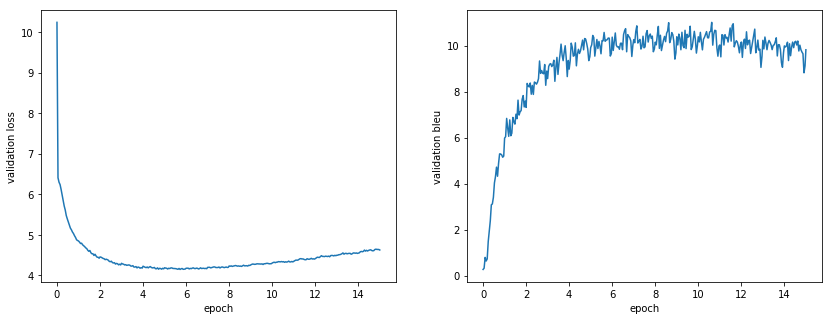

In [9]:
plot_single_learning_curve(load_experiment_log(experiment_name=MODEL_NAME)[0]['results'])

In [10]:
summarize_results(load_experiment_log(experiment_name=MODEL_NAME))[[
    'model_name', 'best_val_loss', 'best_val_bleu', 'runtime', 'dt_created', 
    'num_layers', 'enc_hidden_dim', 'dec_hidden_dim']]

,model_name,best_val_loss,best_val_bleu,runtime,dt_created,num_layers,enc_hidden_dim,dec_hidden_dim
0,vi-rnn-multiplicative-attn,4.14645,0.269214,778.325765,2018-12-09 20:59:48,2,512,1024


In [ ]:
# reload model and test 
encoder = EncoderRNN(rnn_cell_type=RNN_CELL_TYPE, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, 
                     src_max_sentence_len=SRC_MAX_SENTENCE_LEN, enc_dropout=ENC_DROPOUT, 
                     pretrained_word2vec=get_pretrained_emb(vocab[SRC_LANG]['word2vec'], vocab[SRC_LANG]['token2id']))

# # without attention 
# decoder = DecoderRNN(dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS,
#                      targ_vocab_size=TARG_VOCAB_SIZE, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
#                      pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], vocab[TARG_LANG]['token2id']))
# model = EncoderDecoder(encoder, decoder, vocab[TARG_LANG]['token2id']).to(device)

# with additive attention 
decoder = DecoderAttnRNN(rnn_cell_type=RNN_CELL_TYPE, dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, 
                         num_layers=NUM_LAYERS, targ_vocab_size=TARG_VOCAB_SIZE, src_max_sentence_len=SRC_MAX_SENTENCE_LEN, 
                         targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, dec_dropout=DEC_DROPOUT, attention_type=ATTENTION_TYPE,
                         pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], vocab[TARG_LANG]['token2id']))
model = EncoderDecoderAttn(encoder, decoder, vocab[TARG_LANG]['token2id'])

# # with multiplicative attention 
# decoder = DecoderAttnRNN(rnn_cell_type=RNN_CELL_TYPE, dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, 
#                          num_layers=NUM_LAYERS, targ_vocab_size=TARG_VOCAB_SIZE, src_max_sentence_len=SRC_MAX_SENTENCE_LEN, 
#                          targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, dec_dropout=DEC_DROPOUT, attention_type=ATTENTION_TYPE,
#                          pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], vocab[TARG_LANG]['token2id']))
# model = EncoderDecoderAttn(encoder, decoder, vocab[TARG_LANG]['token2id']).to(device) 

In [ ]:
checkpoint = torch.load('model_checkpoints/{}.pth.tar'.format(MODEL_NAME), map_location=device)
model.load_state_dict(checkpoint)